Scanpy quick reference
===

Oana Ursu - 2018-09-06

This notebook is me going through the tutorial at https://nbviewer.jupyter.org/github/theislab/scanpy_usage/blob/master/170505_seurat/seurat.ipynb and adding some personal notes and snippets of code. It is NOT meant as a substitute for that tutorial. Rather it should complement it.

**Goal of the tutorial**

1. Go through the typical functions used in single cell data exploration and understanding what they actually do, as implemented in scanpy.

2. Produce some reference code for auxiliary analyses: e.g. manipulating the scanpy data structure, querying it, etc.

**To run this notebook on your computer**

If you want to follow along
- download the dataset used here: the 3k PBMCs in all popular tutorials, and the data can be downloaded from http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
- change the paths below to where you downloaded the data and where the output files should be written

In [1]:
#in_path=<directory with pbmcs>/filtered_gene_bc_matrices/hg19/
#out_path=<path to output files>

in_path='/ahg/regevdata2/projects/Cell2CellCommunication/sc_explore/data/2018-05-23/filtered_gene_bc_matrices/hg19/'
out_path = '/ahg/regevdata2/projects/Cell2CellCommunication/sc_explore/results/2018-09-06_scanpy/scanpy_basics'
results_file=out_path+'/tutorial'

**Import relevant packages**

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy.api as sc
import inspect

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


scanpy==1.3.1+18.g9be6e82 anndata==0.6.10 numpy==1.15.1 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.19.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


#======================================================================================================
Reading in data
---

**1. Reading in 10X data**

In [3]:
adata = sc.read(in_path + 'matrix.mtx', cache=True).T  # transpose the data
adata.var_names = pd.read_csv(in_path + 'genes.tsv', header=None, sep='\t')[1]
adata.obs_names = pd.read_csv(in_path + 'barcodes.tsv', header=None)[0]
adata

... reading from cache file ./cache/ahg-regevdata2-projects-Cell2CellCommunication-sc_explore-data-2018-05-23-filtered_gene_bc_matrices-hg19-matrix.h5ad
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 2700 × 32738 

In [4]:
adata.var_names_make_unique()

In [5]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738 

- obs = observations (cells)
- var = variables (genes)

**2. Reading in non-mtx data**

If you want to read expression data from a non-mtx file, you can use sc.read_text (or many others as described here https://scanpy.readthedocs.io/en/latest/api/index.html#reading). **IMPORTANT**: for read_text, you need the genes as columns, cells as rows.

**3. Reading in data from multiple channels**

I personally use `cellranger aggr` to aggregate the matrices across channels, and then use the generic command for reading in 10X data.

#======================================================================================================
The scanpy object (part 1)
===

The scanpy object (`adata` above) stores the data. Here is a nice description of the exact data structure: https://scanpy.readthedocs.io/en/latest/basic_usage.html#anndata

**Components of the scanpy object**:
- expression data
    - `adata.X`. To get this as an array, do `my_array_adata=adata.X.toarray()`
- names of the cells
    - `adata.obs_names`
- names of the genes
    - `adata.var_names`
- have additional cell attributes? e.g. perturbations in perturb-seq. set them as `adata.obs[attribute_name]=attribute_vector` where `attribute_vector` is a vector of the same length as the number of cells containing the attribute with the name `attribute_name`. 
- similar story for attributes for genes. just set `adata.var[attribute_name]=attribute_vector`

**Examples printing these components**

Below are some examples accessing these different components.
- NOTE: This is the raw data. It might make more sense to do explore this object after filtering, normalizing, etc. the data.

1 | Print the object `adata`. We see it has 2700 cells with 32738 cells.

In [6]:
print('== adata object ==')
print(adata)

== adata object ==
AnnData object with n_obs × n_vars = 2700 × 32738 


2 | Print the expression data only. We notice that it is stored as a csr_matrix.

In [7]:
print('== adata expression data ==')
print('class:',adata.X.__class__.__name__)
print('shape:',adata.X.shape)

== adata expression data ==
class: csr_matrix
shape: (2700, 32738)


3 | Convert the expression data to a numpy array.

In [8]:
print('== adata expression data (as array) ==')
adata_np=adata.X.toarray()
print('class:',adata_np.__class__.__name__)
print('shape:',adata_np.shape)

== adata expression data (as array) ==
class: ndarray
shape: (2700, 32738)


4 | cell names and gene names
- These will be very useful for subsetting the expression data, e.g. to look at the expression of a specific set of genes, or to look at a specific subset of cells.

In [9]:
print('first few cell names (class): ',adata.obs_names[:3].__class__.__name__)
print('first few cell names: ',adata.obs_names[:3])
print('first few gene names (class): ',adata.var_names[:3].__class__.__name__)
print('first few gene names: ',adata.var_names[:3])

first few cell names (class):  Index
first few cell names:  Index(['AAACATACAACCAC-1', 'AAACATTGAGCTAC-1', 'AAACATTGATCAGC-1'], dtype='object', name=0)
first few gene names (class):  Index
first few gene names:  Index(['MIR1302-10', 'FAM138A', 'OR4F5'], dtype='object')


**Example quick queries of the data**

1 | get the expression for a single gene and make a histogram across all cells.

The genes and cell names can be used to index into the `adata`. For instance, to select the expression data for a given gene, you can do `adata[:,gene_name].X`. 

[0. 0. 1. ... 1. 0. 1.]


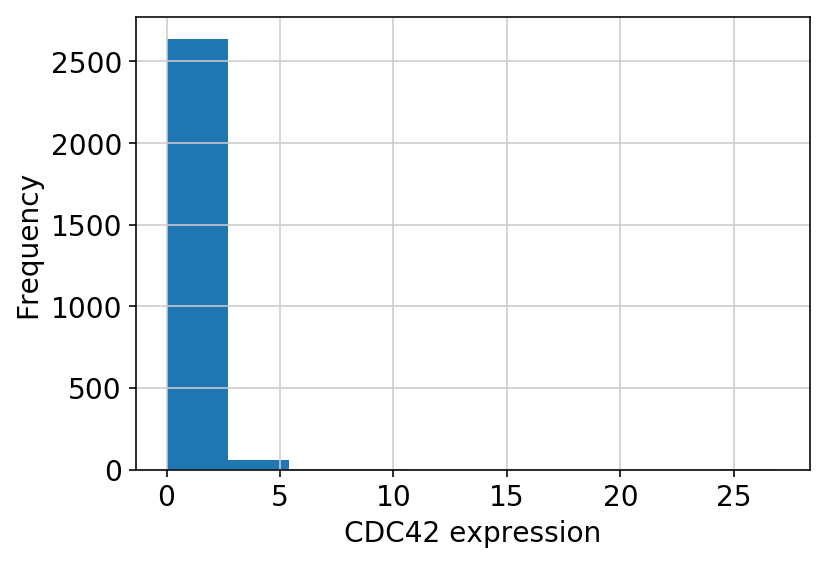

In [10]:
gene_x='CDC42'
gene_x_expr_np=adata[:,gene_x].X.toarray()
print(gene_x_expr_np)

plt.hist(gene_x_expr_np)
plt.xlabel(gene_x+' expression')
plt.ylabel('Frequency')
plt.show()

2 | get the distribution of expression in one of the cells

[0. 0. 0. ... 0. 0. 0.]


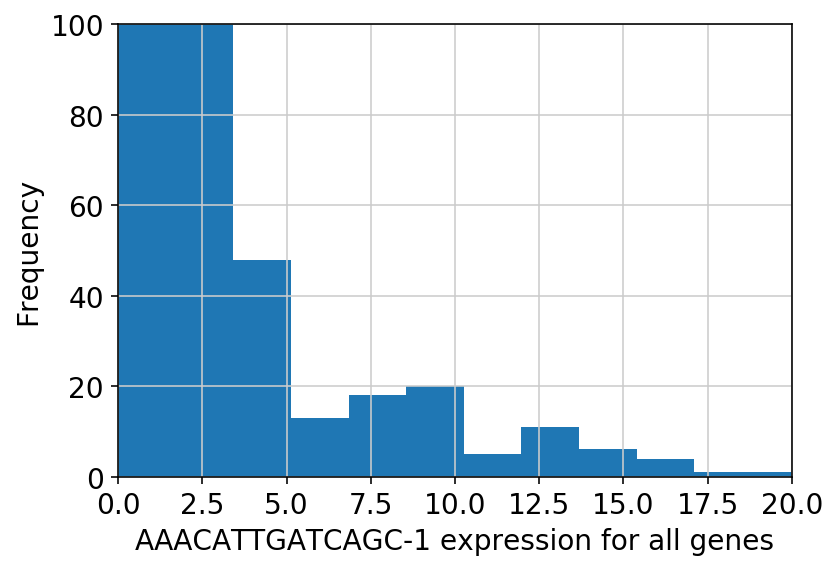

In [11]:
cell_x='AAACATTGATCAGC-1'
gene_x_expr_np=adata[cell_x,:].X.toarray()
print(gene_x_expr_np)

plt.hist(gene_x_expr_np,100)
plt.xlabel(cell_x+' expression for all genes')
plt.ylabel('Frequency')
plt.xlim(0,20)
plt.ylim(0,100)
plt.show()

3 | get the cells that express the gene above some value

# cells with CDC42 above 2: 62
example cell names:  Index(['AATGGCTGTAAAGG-1', 'AATGTAACGTTTGG-1', 'AATTGATGTCGCAA-1'], dtype='object', name=0)


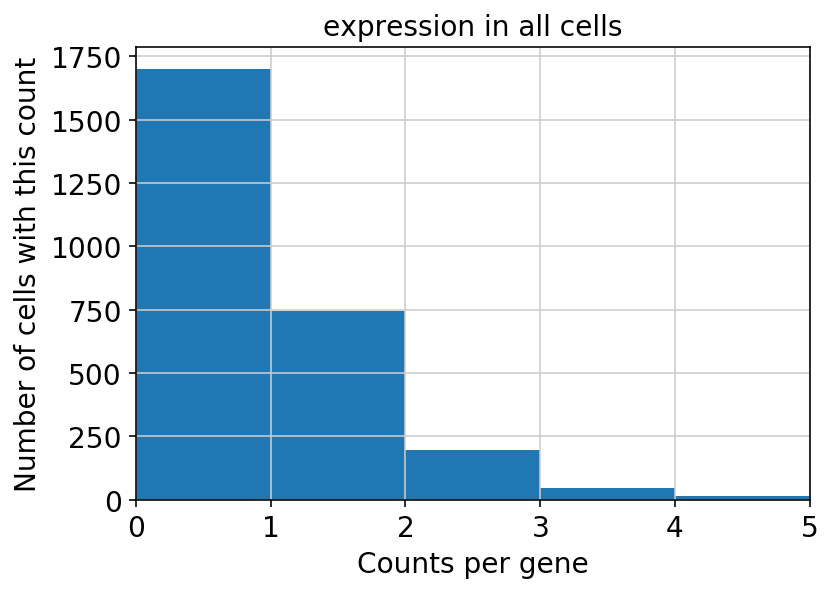

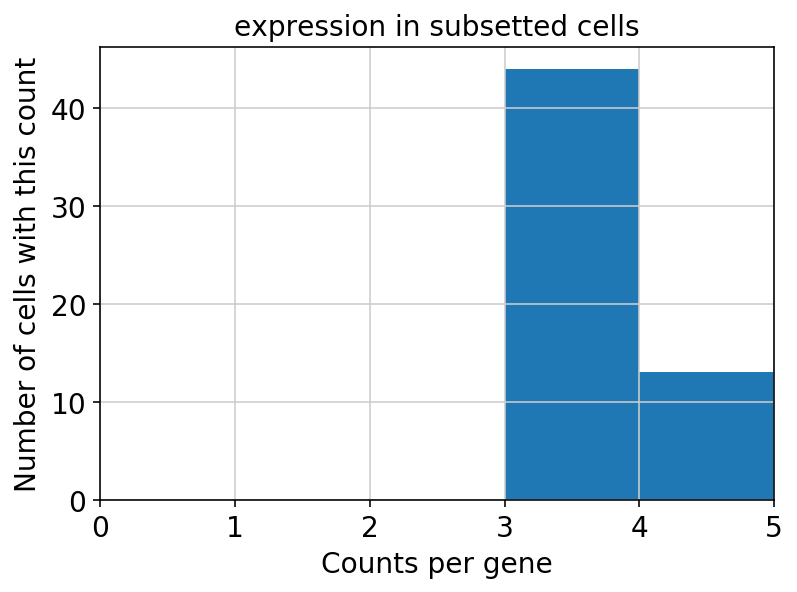

In [12]:
expr_threshold=2
gene_x_on_idx=adata[:,gene_x].X.toarray()>expr_threshold
cells_gene_x=adata.obs_names[gene_x_on_idx]

print('# cells with '+gene_x+' above '+str(expr_threshold)+':',len(cells_gene_x))
print('example cell names: ',cells_gene_x[:3])

plt.hist(adata[:,gene_x].X.toarray(),range(100))
plt.xlim(0,5)
plt.title('expression in all cells')
plt.xlabel('Counts per gene')
plt.ylabel('Number of cells with this count')
plt.show()

plt.hist(adata[:,gene_x].X.toarray()[gene_x_on_idx],range(100))
plt.xlim(0,5)
plt.title('expression in subsetted cells')
plt.xlabel('Counts per gene')
plt.ylabel('Number of cells with this count')
plt.show()

More operations will be displayed later, after we properly filter and normalize the data.

Basic filtering
==

Filter out cells with <200 genes, or genes with <3 cells.
Then visualize the number of genes, number of counts and percent mitochondrial umis. (Note that the percent mitochondrial is computed to count the umis falling in genes whose name starts with "MT-". That works fine for human but may need to be modified for other organisms. Then filter cells based on these considerations. The exact filtering criteria vary with datasets.

In [13]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

filtered out 19024 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 2700 × 13714 
    obs: 'n_genes'
    var: 'n_cells'

In [14]:
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

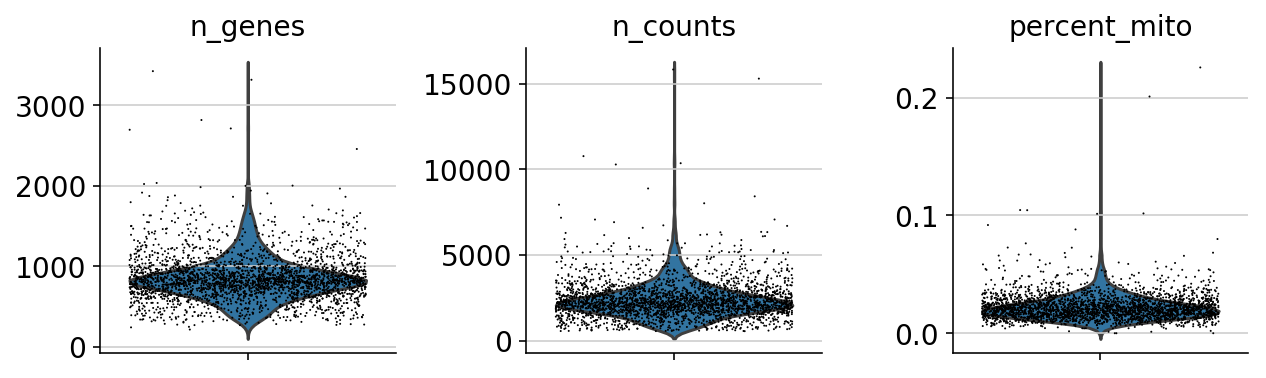

In [15]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

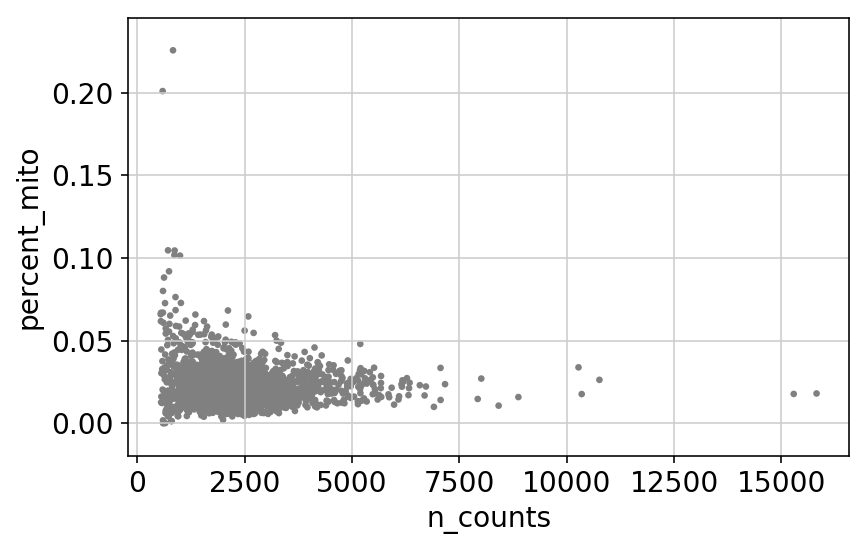

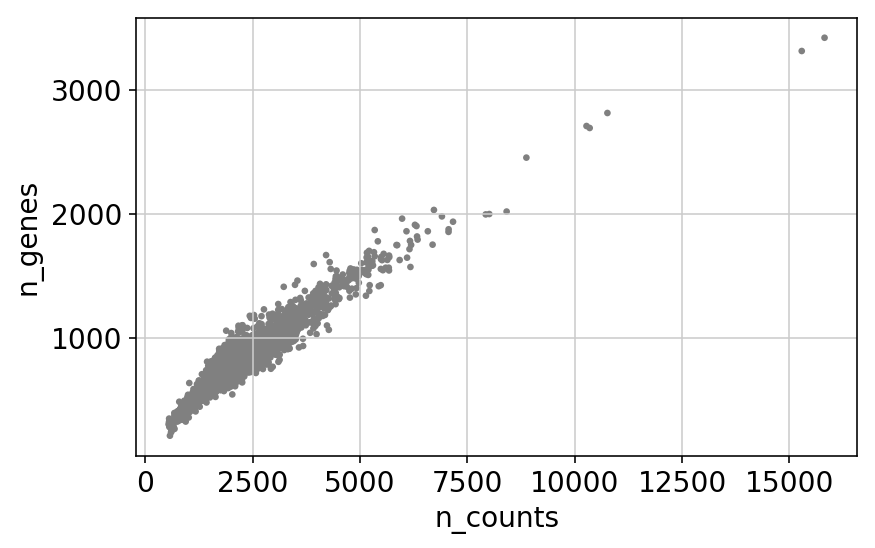

In [16]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

Here is where the filtering actually happens.

In [17]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

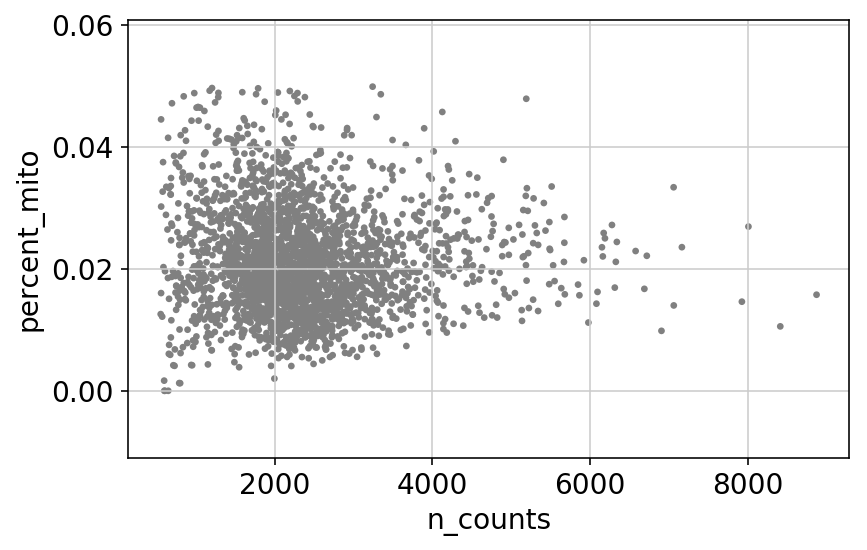

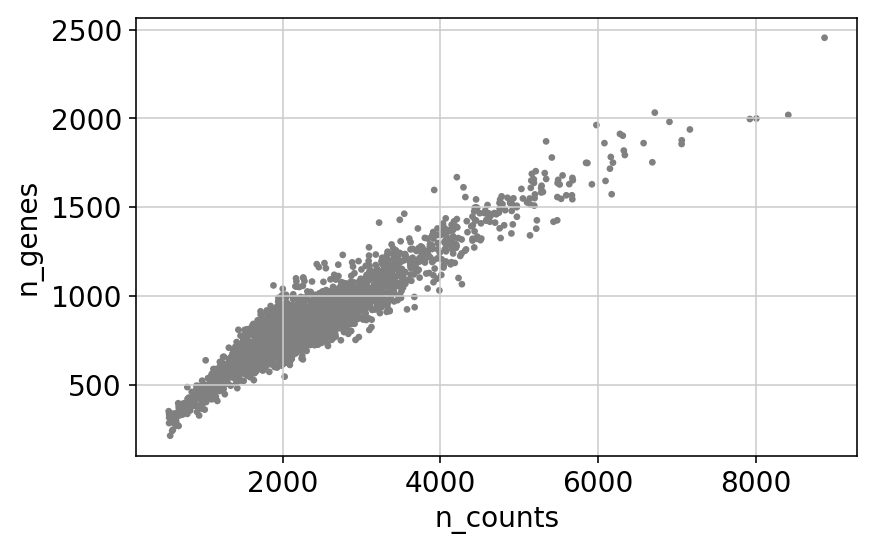

In [18]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [19]:
adata

View of AnnData object with n_obs × n_vars = 2638 × 13714 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

Fun note: starting with scanpy v 1.3, you can get a quick glance of the most expressed genes, as below. Note again that this is unnormalized data, though.

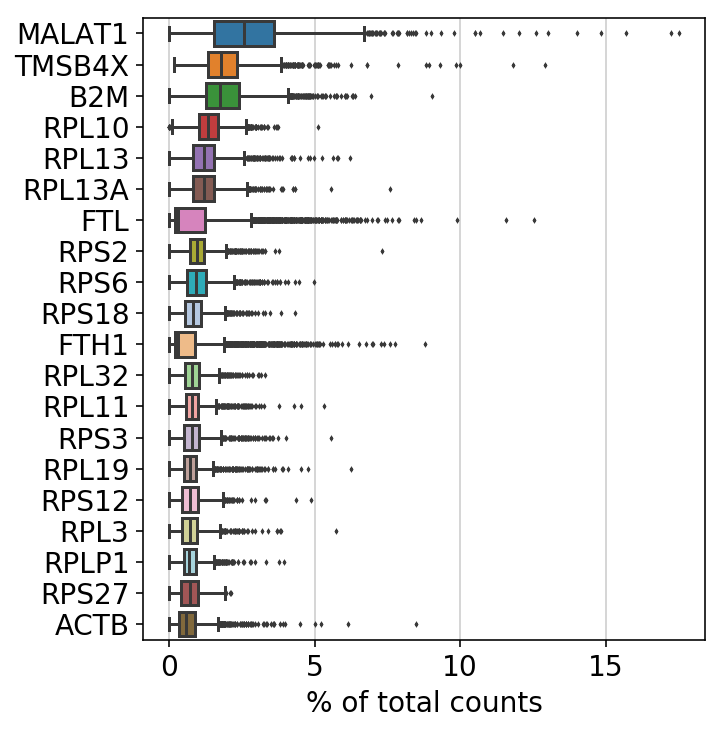

In [20]:
sc.pl.highest_expr_genes(adata, n_top=20)

Normalization
===

Usually, to normalize the expression data, we scale the counts so that they sum to the same amount across cells. Note that you might also want to downsample the counts before performing the normalization. 

**downsampling example**

... reading from cache file ./cache/ahg-regevdata2-projects-Cell2CellCommunication-sc_explore-data-2018-05-23-filtered_gene_bc_matrices-hg19-matrix.h5ad
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 19024 genes that are detected in less than 3 cells


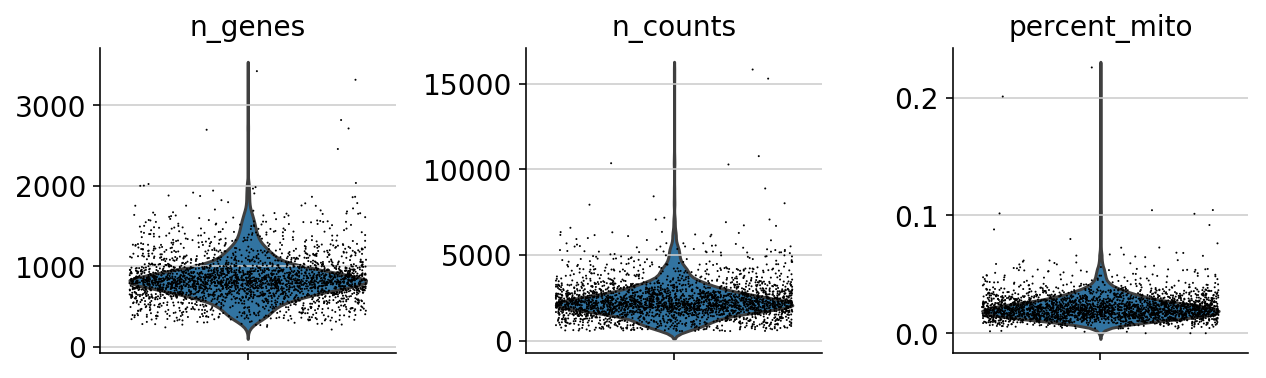

In [21]:
#read in the data again separately for this, so as not to interfere with adata that is used in the rest of the notebook

adata_subsample = sc.read(in_path + 'matrix.mtx', cache=True).T  # transpose the data
adata_subsample.var_names = pd.read_csv(in_path + 'genes.tsv', header=None, sep='\t')[1]
adata_subsample.obs_names = pd.read_csv(in_path + 'barcodes.tsv', header=None)[0]
adata_subsample.var_names_make_unique()

sc.pp.filter_cells(adata_subsample, min_genes=200)
sc.pp.filter_genes(adata_subsample, min_cells=3)

adata_subsample

mito_genes = [name for name in adata_subsample.var_names if name.startswith('MT-')]
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
adata_subsample.obs['percent_mito'] = np.sum(
    adata_subsample[:, mito_genes].X, axis=1).A1 / np.sum(adata_subsample.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata_subsample.obs['n_counts'] = adata_subsample.X.sum(axis=1).A1

sc.pl.violin(adata_subsample, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

In [22]:
#===================
#downsampling command
#===================
adata_subsample=sc.pp.downsample_counts(adata_subsample, target_counts=2500,copy=True)
#===================

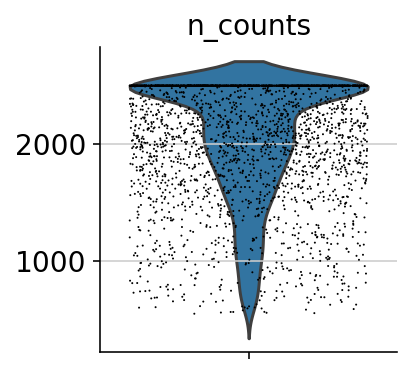

In [23]:
adata_subsample.obs['n_counts'] = adata_subsample.X.sum(axis=1).A1
sc.pl.violin(adata_subsample, ['n_counts'],
             jitter=0.4, multi_panel=True)

**Normalization step**

Here's the actual code.

In [24]:
print(inspect.getsource(sc.pp.normalize_per_cell))

def normalize_per_cell(data, counts_per_cell_after=None, counts_per_cell=None,
                       key_n_counts=None, copy=False, layers=[], use_rep=None):
    """Normalize total counts per cell.

    Normalize each cell by total counts over all genes, so that every cell has
    the same total count after normalization.

    Similar functions are used, for example, by Seurat [Satija15]_, Cell Ranger
    [Zheng17]_ or SPRING [Weinreb17]_.

    Parameters
    ----------
    data : :class:`~anndata.AnnData`, `np.ndarray`, `sp.sparse`
        The (annotated) data matrix of shape `n_obs` × `n_vars`. Rows correspond
        to cells and columns to genes.
    counts_per_cell_after : `float` or `None`, optional (default: `None`)
        If `None`, after normalization, each cell has a total count equal
        to the median of the *counts_per_cell* before normalization.
    counts_per_cell : `np.array`, optional (default: `None`)
        Precomputed counts per cell.
    key_n_counts : `str`,

In [25]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

In [26]:
print(adata.X.toarray().sum(axis=1).shape)
adata.X.toarray().sum(axis=1)

(2638,)


array([10000.   , 10000.001, 10000.   , ..., 10000.   , 10000.   ,
        9999.999], dtype=float32)

"Take the log" 
==

The final step for obtaining the so-called "raw" data is to convert the normalized values to log(count+1), for which we can use the function `sc.pp.log1p`. 

**IMPORTANT (part 1)**: The resulting "raw" data will be saved as `adata.raw=sc.pp.log1p(adata, copy=True)`. This does **NOT** replace the values in **adata** with the log1p, but rather gives you an object, **adata.raw** that has the log1p values. This is useful, because in the following steps we will be processing the expression data in `adata` (e.g. we will subset to variable genes, do PCA, etc.), and we want to keep a record of this raw data in `adata.raw`, which we can use for plotting the expression values onto t-SNE plots, etc.

**IMPORTANT (part 2)**: here, I store the log1p data into `adata.raw`, and leave the normalized counts in `adata`. The values in `adata` (non log1p-ed) will be used for the variable gene selection in the next step. Only after that do I do log1p for the `adata` as well.

Fun facts about `sc.pp.log1p`:
- the log used is the natural logarithm (from https://scanpy.readthedocs.io/en/latest/api/scanpy.api.pp.log1p.html?highlight=log1p)
- uses the method np.log1p (https://docs.scipy.org/doc/numpy/reference/generated/numpy.log1p.html)

Below is the actual code

In [27]:
print(inspect.getsource(sc.pp.log1p))

def log1p(data, copy=False, chunked=False, chunk_size=None):
    """Logarithmize the data matrix.

    Computes `X = log(X + 1)`, where `log` denotes the natural logarithm.

    Parameters
    ----------
    data : :class:`~anndata.AnnData`, `np.ndarray`, `sp.sparse`
        The (annotated) data matrix of shape `n_obs` × `n_vars`. Rows correspond
        to cells and columns to genes.
    copy : `bool`, optional (default: `False`)
        If an :class:`~anndata.AnnData` is passed, determines whether a copy
        is returned.

    Returns
    -------
    Returns or updates `data`, depending on `copy`.
    """
    if copy:
        data = data.copy()

    def _log1p(X):
        if issparse(X):
            np.log1p(X.data, out=X.data)
        else:
            np.log1p(X, out=X)

        return X

    if isinstance(data, AnnData):
        if chunked:
            for chunk, start, end in data.chunked_X(chunk_size):
                 data.X[start:end] = _log1p(chunk)
        else:
         

In [28]:
print(np.log1p(2))
print(np.exp(np.log1p(2)))
print(np.exp(np.log(2+1)))

1.0986122886681096
2.9999999999999996
3.0000000000000004


From the tutorial: "Set the .raw attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object returned by sc.pp.log1p"

In [29]:
adata.raw = sc.pp.log1p(adata, copy=True)
print(adata)
print('adata.raw:',adata.raw)
print('class of adata raw:',adata.raw.X.__class__.__name__)

AnnData object with n_obs × n_vars = 2638 × 13714 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'
adata.raw: <anndata.base.Raw object at 0x2b72d71e1390>
class of adata raw: SparseCSRView


We can access `adata.raw` similar to how we access `adata`.

In [30]:
adata_raw_np=adata.raw.X.toarray()
print(adata_raw_np.__class__.__name__)
print(adata_raw_np.shape)

ndarray
(2638, 13714)


And note that we can subset by genes and cells, similar to how we do it for `adata`. e.g. `adata.raw[:,gene_x].X`

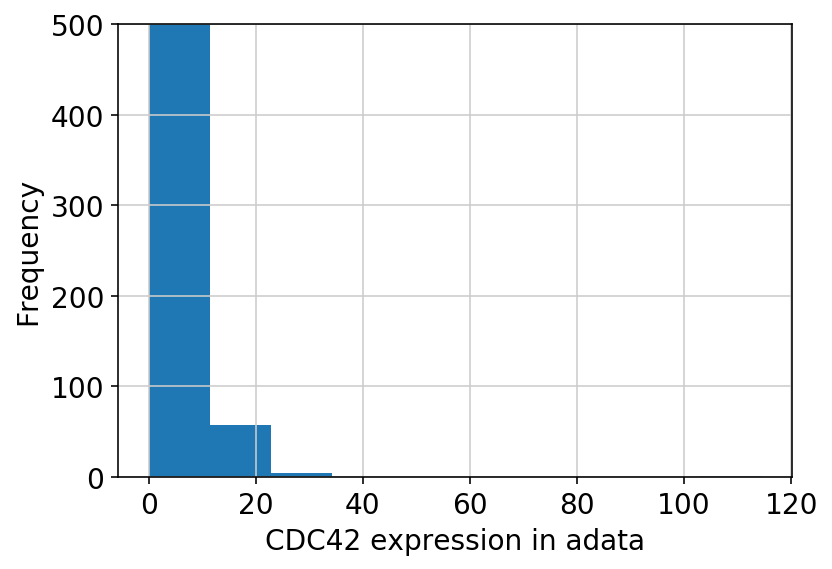

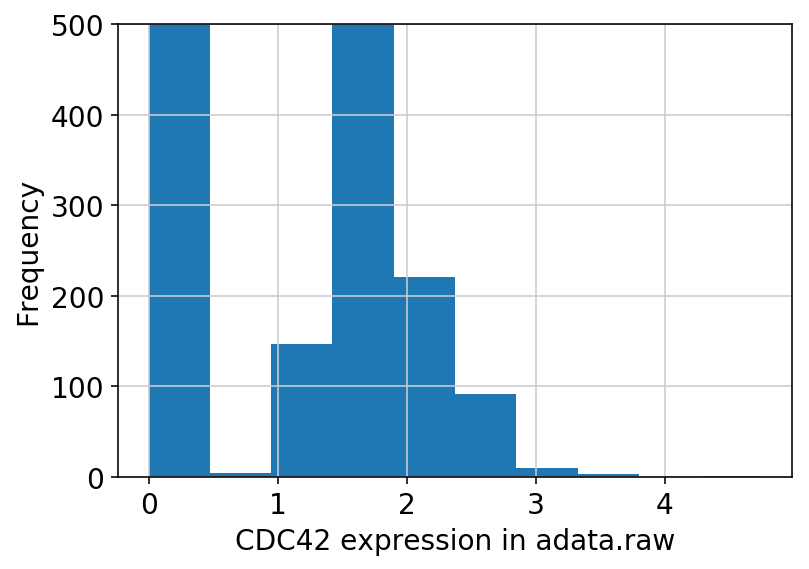

In [31]:
gene_x='CDC42'

#adata
gene_x_expr_np=adata[:,gene_x].X.toarray()

plt.hist(gene_x_expr_np)
plt.xlabel(gene_x+' expression in adata')
plt.ylabel('Frequency')
plt.ylim(0,500)
plt.show()

#adata raw
gene_x_expr_np=adata.raw[:,gene_x].X

plt.hist(gene_x_expr_np)
plt.xlabel(gene_x+' expression in adata.raw')
plt.ylabel('Frequency')
plt.ylim(0,500)
plt.show()

At this point I like to save the object, as it has the raw basic analysis. Note that `adata` has the normalized counts, while `adata.raw` has the `log1p(normalized counts +1)`.

In [32]:
adata.write(results_file+'.basic.h5ad')

Variable genes
===

The usual next step is to identify variable genes. Why not use all genes you say? It's because before doing PCA, each gene is scaled such that it has mean 0 and variance 1. We want to remove genes that actually vary little in the dataset, so that the PCA can focus on the real variance in expression, rather than the noise.

As we will see below, there are multiple ways to identify variable genes. In addition to the methods implemented in scanpy, there are many other valid ways to choose these variable genes. Given that the downstream analysis basically depend on this, you should give this step serious thought.

Here's the method:

In [33]:
print(inspect.getsource(sc.pp.filter_genes_dispersion))

def filter_genes_dispersion(data,
                            flavor='seurat',
                            min_disp=None, max_disp=None,
                            min_mean=None, max_mean=None,
                            n_bins=20,
                            n_top_genes=None,
                            log=True,
                            copy=False):
    """Extract highly variable genes [Satija15]_ [Zheng17]_.

    If trying out parameters, pass the data matrix instead of AnnData.

    Depending on `flavor`, this reproduces the R-implementations of Seurat
    [Satija15]_ and Cell Ranger [Zheng17]_.

    The normalized dispersion is obtained by scaling with the mean and standard
    deviation of the dispersions for genes falling into a given bin for mean
    expression of genes. This means that for each bin of mean expression, highly
    variable genes are selected.

    Use `flavor='cell_ranger'` with care and in the same way as in
    :func:`~scanpy.api.pp.recipe_zheng17`.

    

**2 flavors of variable gene selection implemented in scanpy**

There are two methods implemented, called the 'seurat' flavor and the 'cellranger' flavor.

- what data the method expects:
    - flavor='seurat' needs adata.X, and log=True (both of these are the default)
    - flavor='cell_ranger' needs adata.raw (the logarithmized data) and log=False

**seurat flavor**

-add small values to genes with mean 0.

-compute dispersion as log(var/mean). 

-compute mean as log1p(mean).

-group genes into bins by their means.

-get the normalized dispersion, done separately in each bin. in each bin of expression mean, get a zscore for the dispersion based on mean, sd of dispersion in that bin.
= (dispersion - mean dispersion in the bin)/sd dispersion in the bin

-filter by the user-defined thresholds on mean expression and **normalized** dispersion (so, look in the left plot)

#=========================================================

Sooo, the **meaning of the dispersions** in the plots below are:

-normalized dispersion=z-score by expression bin

-unnormalized dispersion=dispersion computed as log(var/mean).

#=========================================================

Example output for the 'seurat' flavor:

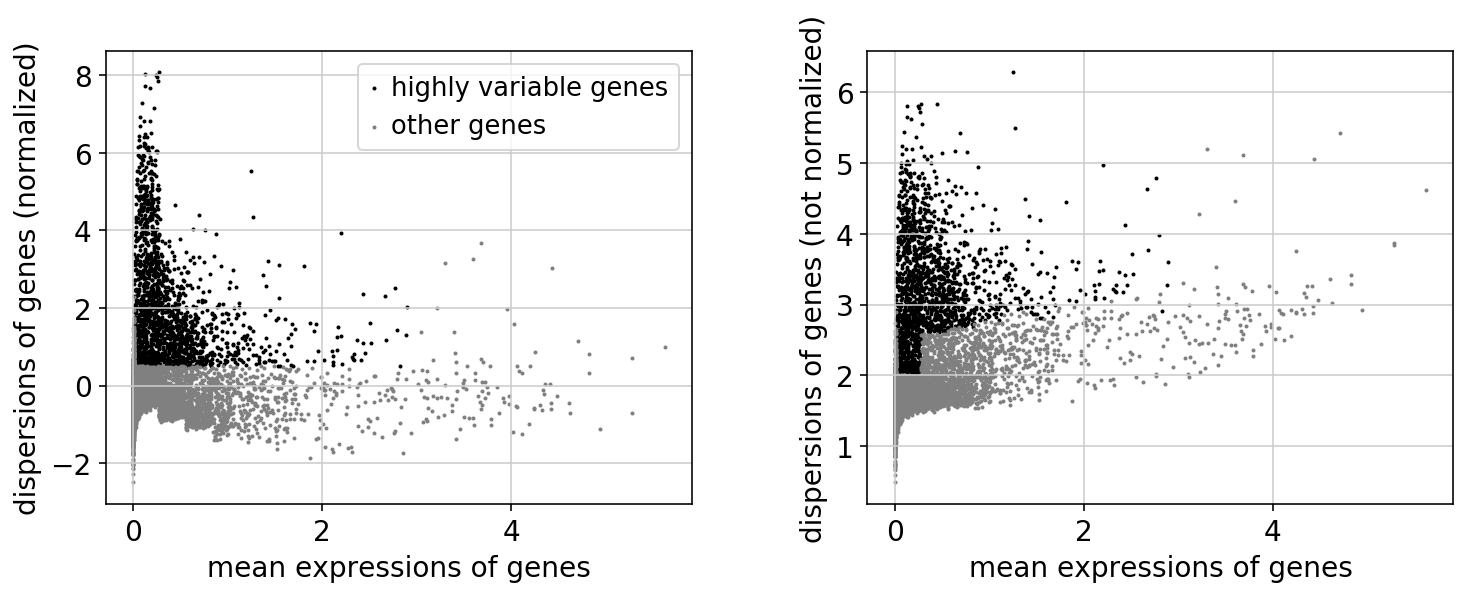

In [34]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

**cellranger flavor** 

-use the provided log1p'd data to get mean and dispersion.

-bin expression mean by percentile (10 to 105 by 5% increments)

-normalize dispersion = absolute value (dispersion - median dispersion)/sd dispersion. (again, this is computed per bin)

-you decide how many n_top_genes to get back as variable. See below what happens when this parameter is provided vs not.

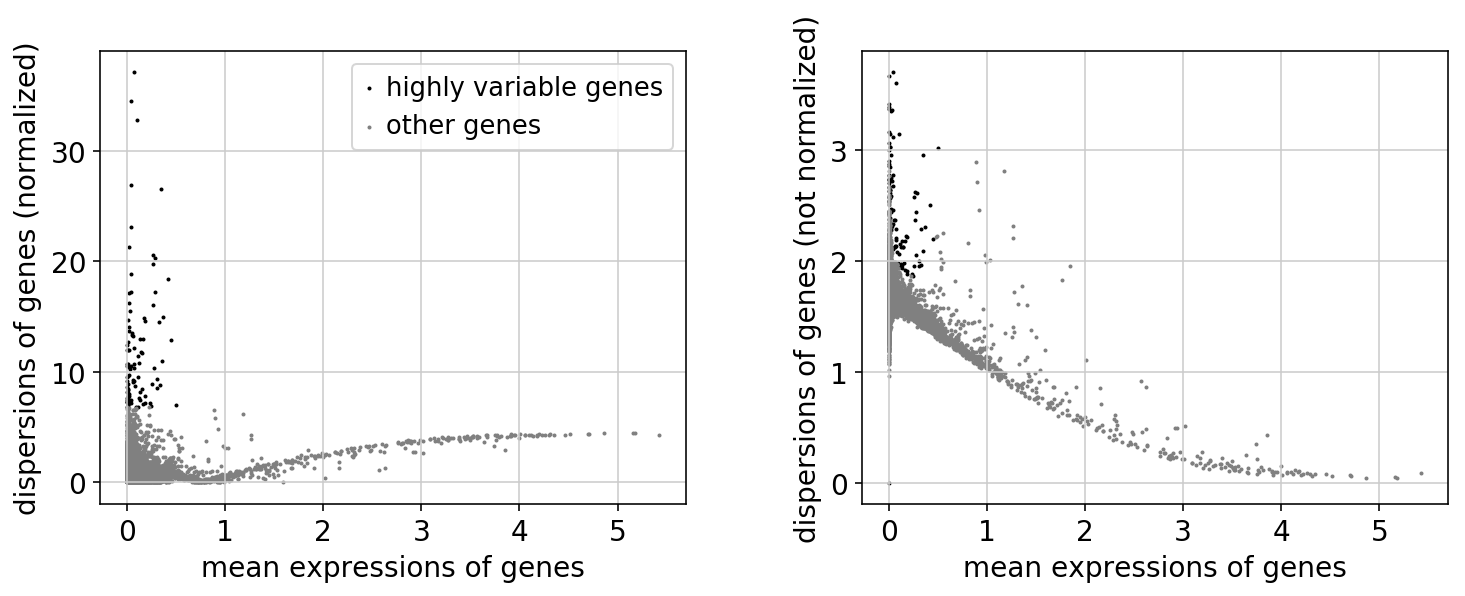

In [35]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.raw.X, flavor='cell_ranger',log=False,n_top_genes=100)
sc.pl.filter_genes_dispersion(filter_result)

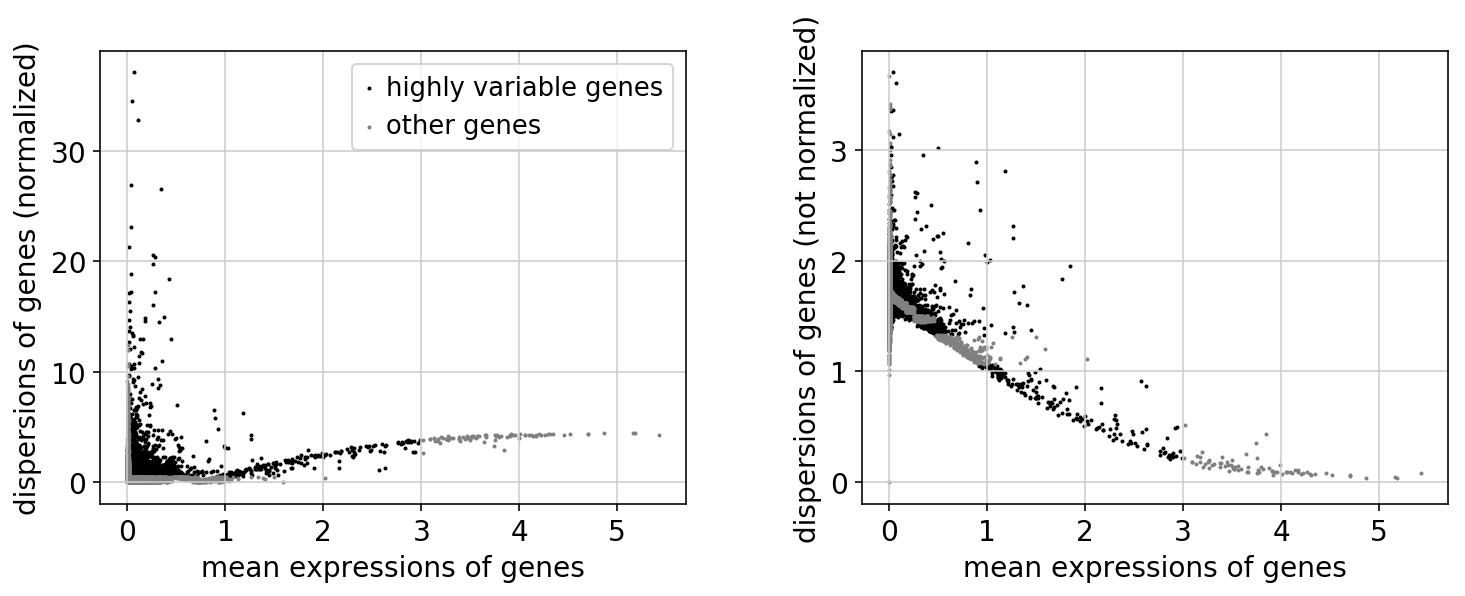

In [36]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.raw.X, flavor='cell_ranger',log=False)
sc.pl.filter_genes_dispersion(filter_result)

For the purposes of this tutorial, I will just go with the Seurat flavor.

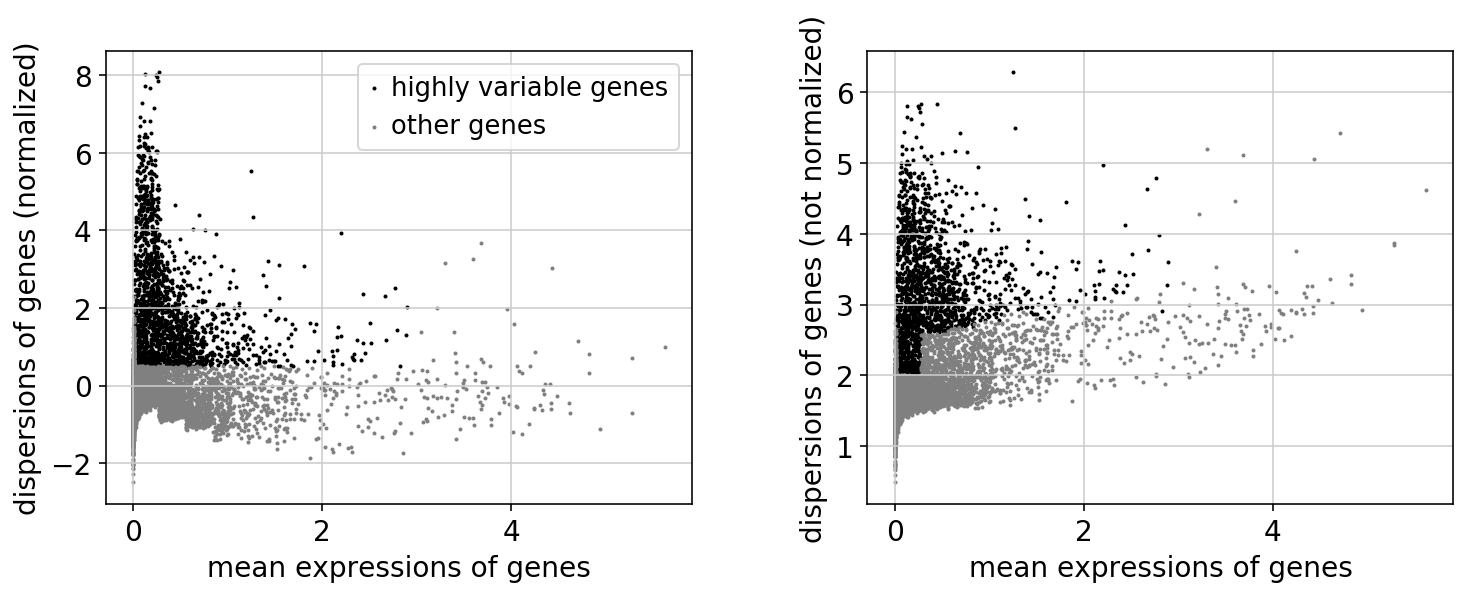

In [37]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

the above just gives you variable genes. below is the filtering.

In [38]:
adata = adata[:, filter_result.gene_subset]
adata
print('adata has a different shape now:',adata.X.shape)
print('adata.raw not affected:',adata.raw.X.shape)

adata has a different shape now: (2638, 1838)
adata.raw not affected: (2638, 13714)


log1p the remaining data

In [39]:
sc.pp.log1p(adata)

Check that `adata` and `adata.raw` store the same values now.

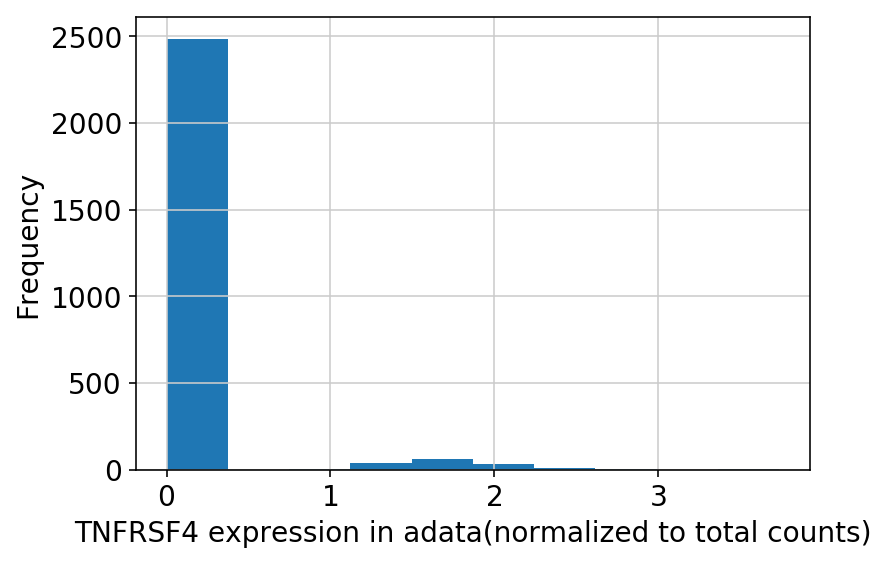

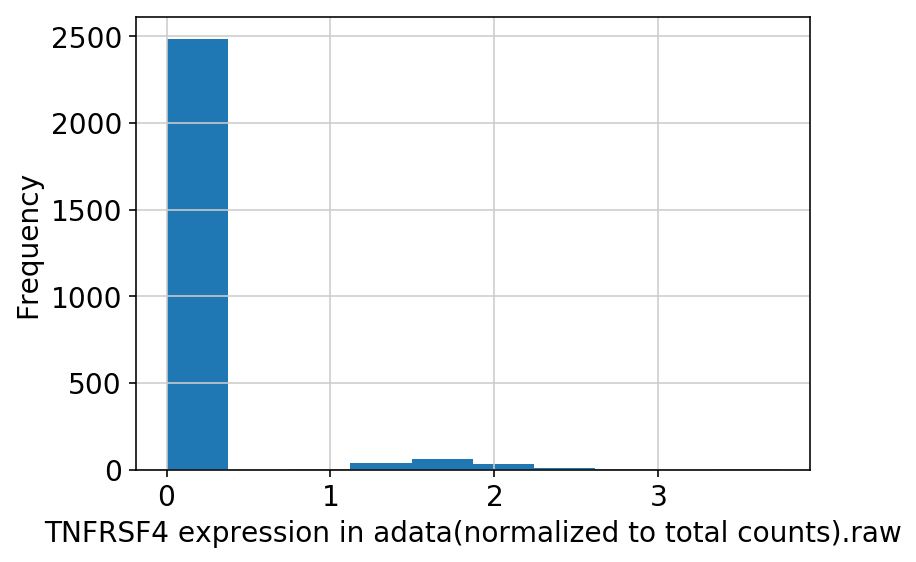

In [42]:
gene_x='TNFRSF4'
gene_x_expr=adata[:,gene_x].X.toarray()
plt.hist(gene_x_expr)
plt.xlabel(gene_x+' expression in adata(normalized to total counts)')
plt.ylabel('Frequency')
plt.show()

gene_x_expr=adata.raw[:,gene_x].X
plt.hist(gene_x_expr)
plt.xlabel(gene_x+' expression in adata(normalized to total counts).raw')
plt.ylabel('Frequency')
plt.show()

Looks good.

Regressing out co-variates
===

In [43]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
adata

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:15.86)


AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

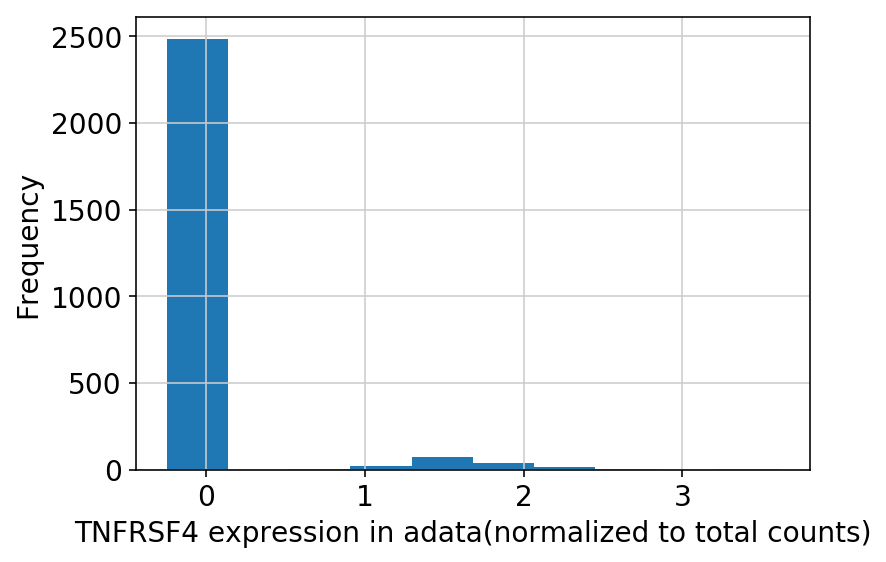

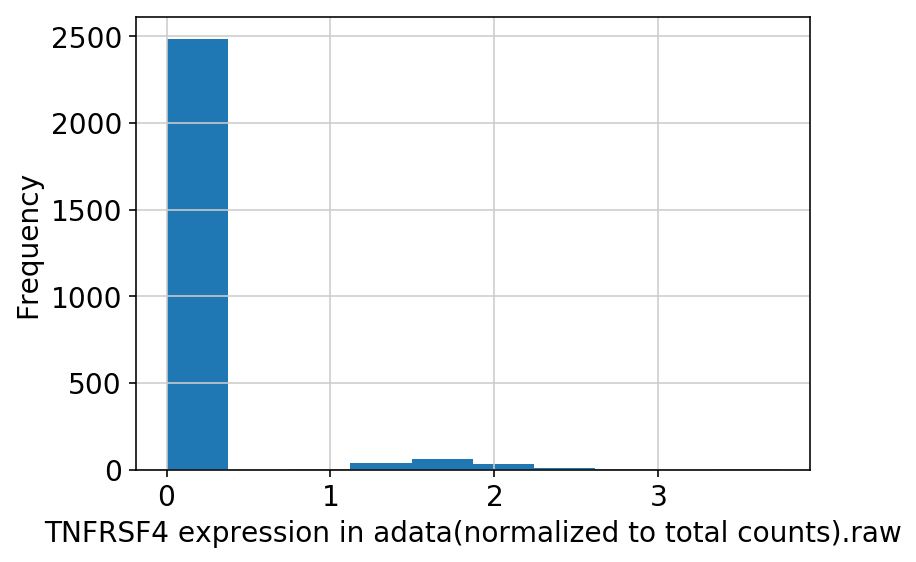

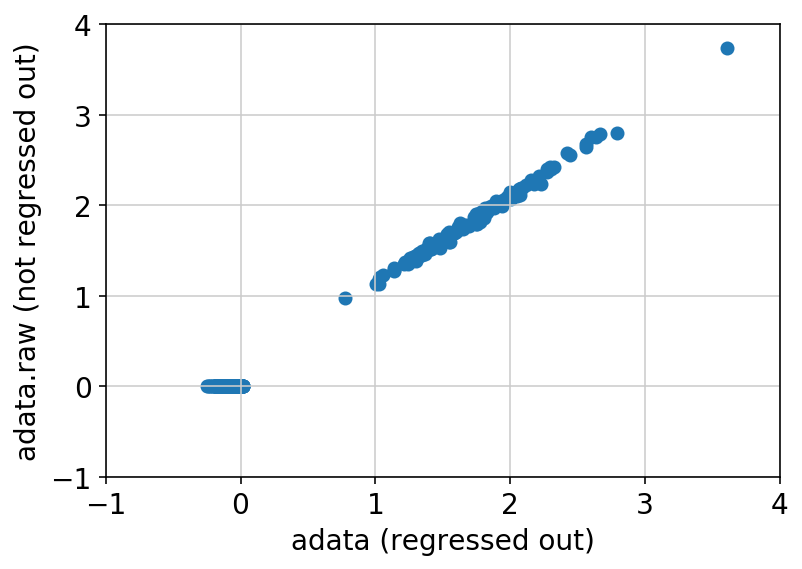

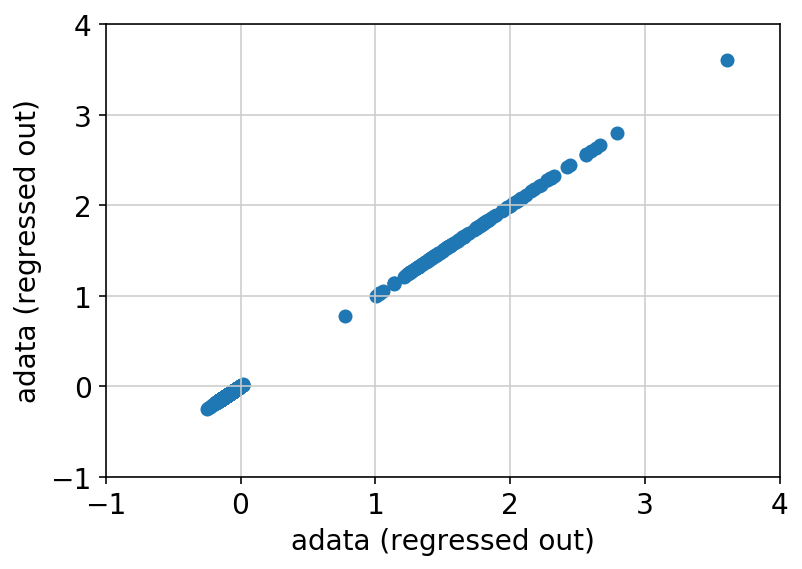

In [44]:
gene_x='TNFRSF4'

gene_x_expr=adata[:,gene_x].X.toarray()
plt.hist(gene_x_expr)
plt.xlabel(gene_x+' expression in adata(normalized to total counts)')
plt.ylabel('Frequency')
plt.show()

gene_x_expr=adata.raw[:,gene_x].X
plt.hist(gene_x_expr)
plt.xlabel(gene_x+' expression in adata(normalized to total counts).raw')
plt.ylabel('Frequency')
plt.show()

plt.scatter(adata[:,gene_x].X.toarray(),adata.raw[:,gene_x].X)
plt.xlabel('adata (regressed out)')
plt.ylabel('adata.raw (not regressed out)')
plt.xlim(-1,4)
plt.ylim(-1,4)
plt.show()

plt.scatter(adata[:,gene_x].X.toarray(),adata[:,gene_x].X.toarray())
plt.xlabel('adata (regressed out)')
plt.ylabel('adata (regressed out)')
plt.xlim(-1,4)
plt.ylim(-1,4)
plt.show()

So, yes, regressing out made some small changes.

Scaling values
===

Scale data to unit variance and zero mean.

In [45]:
sc.pp.scale(adata, max_value=10)

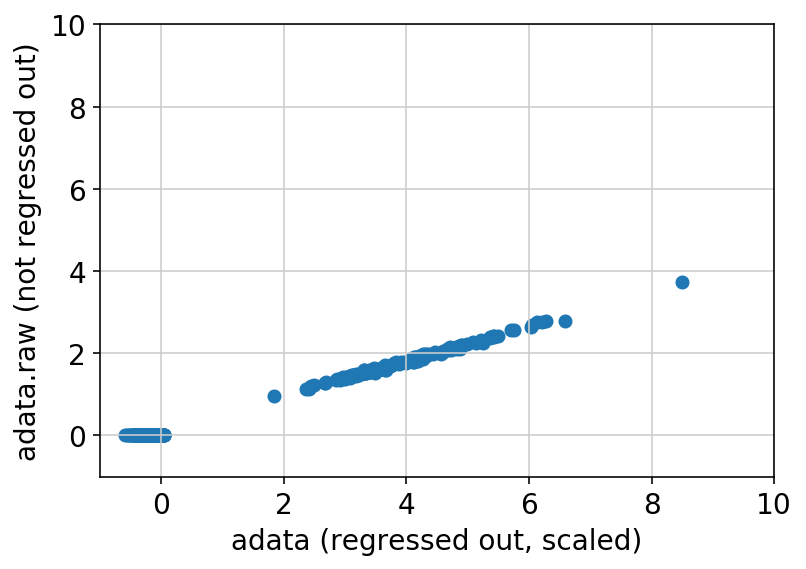

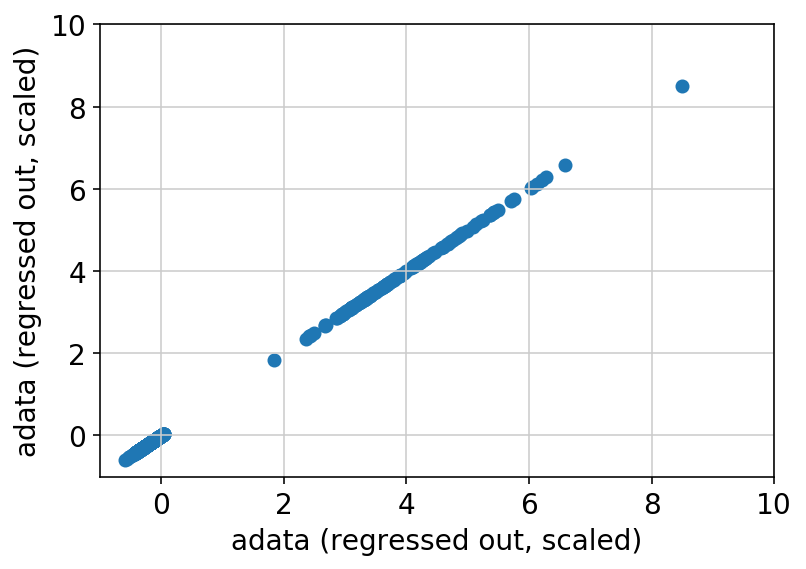

In [46]:
plt.scatter(adata[:,gene_x].X.toarray(),adata.raw[:,gene_x].X)
plt.xlabel('adata (regressed out, scaled)')
plt.ylabel('adata.raw (not regressed out)')
plt.xlim(-1,10)
plt.ylim(-1,10)
plt.show()

plt.scatter(adata[:,gene_x].X.toarray(),adata[:,gene_x].X)
plt.xlabel('adata (regressed out, scaled)')
plt.ylabel('adata (regressed out, scaled)')
plt.xlim(-1,10)
plt.ylim(-1,10)
plt.show()

PCA
===

You can set the number of components with `n_comps`. 

Note that one should use a principled way to choose the number of principal components. 

Also note that UMAP in later steps uses the number of PCs specified in `n_comps` whereas t-SNE takes that number as an argument (`n_pcs`).

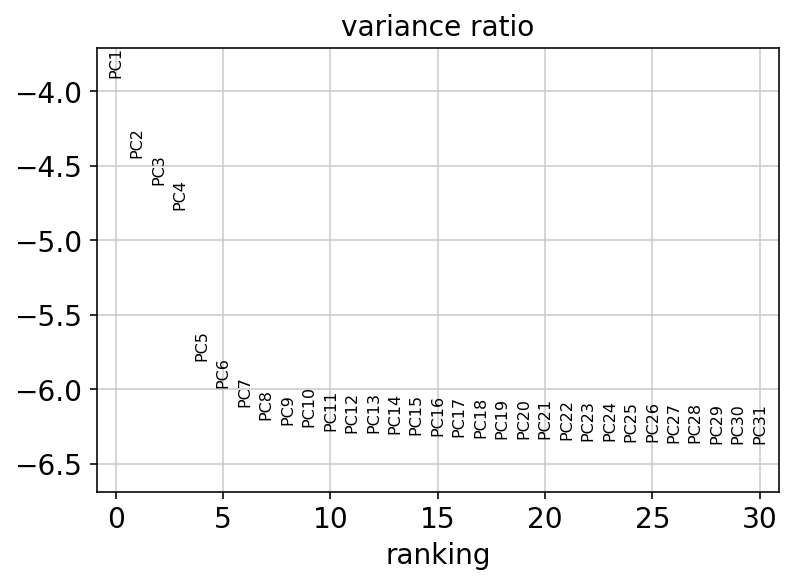

In [51]:
sc.tl.pca(adata,svd_solver='arpack',n_comps=40)
adata.obsm['X_pca'] *= -1
sc.pl.pca_variance_ratio(adata, log=True)

Low dim embedding
===

**UMAP**

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:02.11) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:07.90) --> added
    'X_umap', UMAP coordinates (adata.obsm)


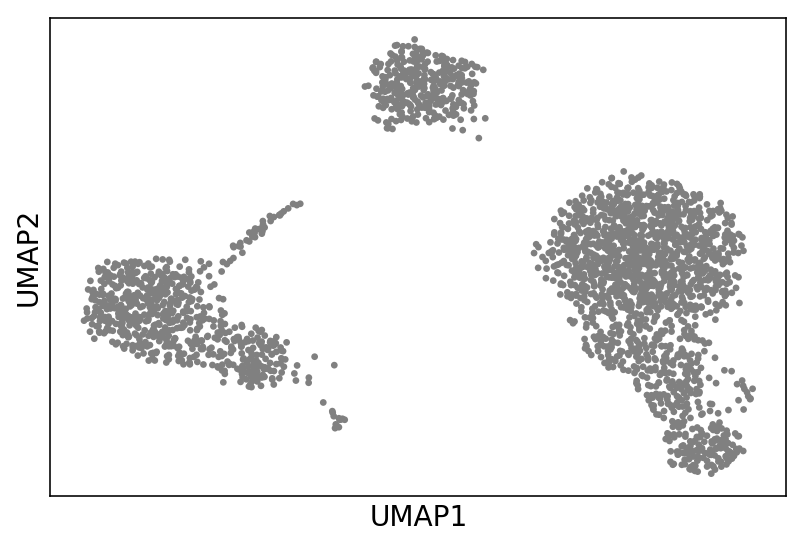

In [53]:
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata)

**tSNE**

In [ ]:
sc.tl.tsne(adata)
sc.pl.tsne(adata)

computing tSNE
    using 'X_pca' with n_pcs = 40
    using sklearn.manifold.TSNE with a fix by D. DeTomaso


Clustering and annotating embeddings
==

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.17) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


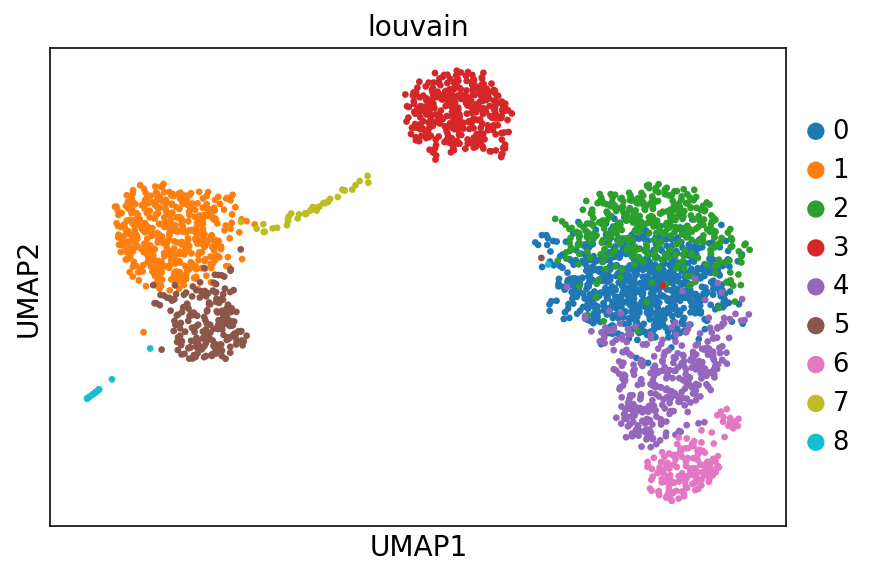

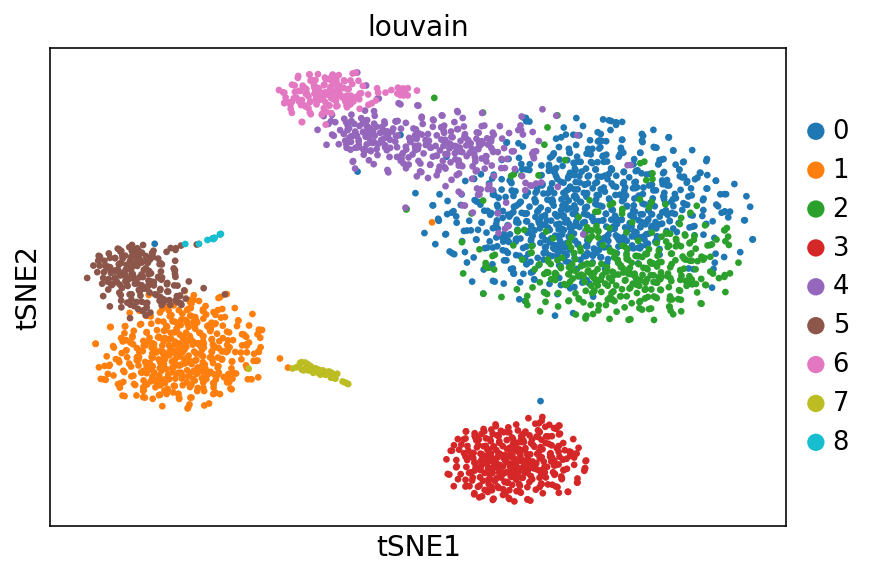

In [50]:
sc.tl.louvain(adata)
sc.pl.umap(adata, color='louvain')
sc.pl.tsne(adata, color='louvain')

Note that `color` can be set to either `louvain` or any gene name, or any attribute associated with the cells that you may have added.